In [1]:
import torch

# see if we have a gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [2]:
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# load the MNIST dataset
transform = transforms.ToTensor()
mnist_train_data = torchvision.datasets.mnist.MNIST(root="./data", train=True, transform=transform, download=True)
mnist_train_loader = DataLoader(mnist_train_data, batch_size=30, shuffle=True, num_workers=2)
mnist_test_data = torchvision.datasets.mnist.MNIST(root="./data", train=False, transform=transform, download=True)
mnist_test_loader = DataLoader(mnist_test_data, batch_size=30, shuffle=False, num_workers=2)
classes = tuple([str(i) for i in range(10)])


9920512it [00:01, 6751769.52it/s]                             
32768it [00:00, 110670.97it/s]           
1654784it [00:00, 2151738.52it/s]                           
8192it [00:00, 36958.35it/s]            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw
Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw
Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


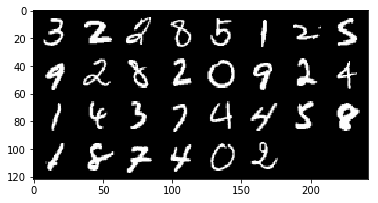

    3     2     2     8     5     1     2     5     9     2     8     2     0     9     2     4     1     4     3     7     4     4     5     8     1     8     7     4     0     2


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# function to show an image
def show_image(img):
	np_image = img.numpy()
	plt.imshow(np.transpose(np_image, (1, 2, 0)))
	plt.show()

# get some random training images
data_iter = iter(mnist_train_loader)
images, labels = data_iter.next()

# show images
show_image(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(len(images))))


In [16]:
import torch.nn as nn
import torch.nn.functional as f
import copy

# make a network
class SimpleMnistNet(nn.Module):
	def __init__(self):
		super(SimpleMnistNet, self).__init__()
		self.cnn1 = nn.Conv2d(1, 5, 3)
		self.cnn2 = nn.Conv2d(5, 10, 3)
		self.cnn3 = nn.Conv2d(10, 16, 3)
		self.fc1 = nn.Linear(16 * 22 * 22, 120, bias=True)
		self.fc2 = nn.Linear(120, 84, bias=True)
		self.fc3 = nn.Linear(84, 10, bias=True)

	def forward(self, x):
		x = self.cnn1(x)
		x = self.cnn2(x)
		x = self.cnn3(x)
		x = x.view(-1, 16 * 22 * 22)
		x = f.relu(self.fc1(x))
		x = f.relu(self.fc2(x))
		x = self.fc3(x)
		return x

net = SimpleMnistNet()


In [17]:
# loss function and optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [30]:
# train the network

PRINT_FREQUENCY = 100

net.to(device)
for epoch in range(2):  # loop over the dataset multiple times

	running_loss = 0.0
	for i, data in enumerate(mnist_train_loader, 0):
		# get the inputs; data is a list of [inputs, labels]
		inputs, labels = data[0].to(device), data[1].to(device)

		# zero the parameter gradients
		optimizer.zero_grad()

		# forward + backward + optimize
		outputs = net(inputs)
		loss = criterion(outputs, labels)
		loss.backward()
		optimizer.step()

		# print statistics
		running_loss += loss.item()
		if i % PRINT_FREQUENCY == (PRINT_FREQUENCY - 1):	# print the occasional mini-batch
			print('[%d, %5d] loss: %.3f' %
				  (epoch + 1, i + 1, running_loss / 2000))
			running_loss = 0.0

print('Finished Training')


[1,   100] loss: 0.005
[1,   200] loss: 0.006
[1,   300] loss: 0.006
[1,   400] loss: 0.006
[1,   500] loss: 0.005
[1,   600] loss: 0.005
[1,   700] loss: 0.006
[1,   800] loss: 0.006
[1,   900] loss: 0.005
[1,  1000] loss: 0.005
[1,  1100] loss: 0.005
[1,  1200] loss: 0.005
[1,  1300] loss: 0.006
[1,  1400] loss: 0.005
[1,  1500] loss: 0.005
[1,  1600] loss: 0.006
[1,  1700] loss: 0.006
[1,  1800] loss: 0.005
[1,  1900] loss: 0.004
[1,  2000] loss: 0.005
[2,   100] loss: 0.005
[2,   200] loss: 0.006
[2,   300] loss: 0.006
[2,   400] loss: 0.005
[2,   500] loss: 0.006
[2,   600] loss: 0.006
[2,   700] loss: 0.005
[2,   800] loss: 0.006
[2,   900] loss: 0.005
[2,  1000] loss: 0.005
[2,  1100] loss: 0.006
[2,  1200] loss: 0.006
[2,  1300] loss: 0.006
[2,  1400] loss: 0.006
[2,  1500] loss: 0.005
[2,  1600] loss: 0.004
[2,  1700] loss: 0.006
[2,  1800] loss: 0.004
[2,  1900] loss: 0.005
[2,  2000] loss: 0.005
Finished Training


In [31]:
# save net state

PATH = './mnist_net_cnn.pth'
torch.save(net.state_dict(), PATH)


In [32]:
# re-load the saved state

net = SimpleMnistNet()
net.load_state_dict(torch.load(PATH))
net.to(device)


SimpleMnistNet(
  (cnn1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))
  (cnn2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1))
  (cnn3): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=7744, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Accuracy of the network on the 10000 test images: 96 %
355 images labeled incorrectly
confusion matrix:


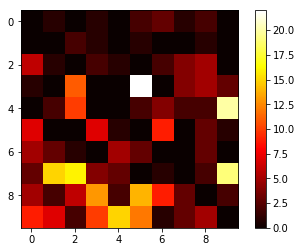

In [40]:
# test the overall accuracy

correct = 0
total = 0
failed = list()
failed_label_counts = np.zeros((len(classes), len(classes)), dtype=int)
with torch.no_grad():
	for data in mnist_test_loader:
		images, labels = data[0].to(device), data[1].to(device)
		outputs = net(images)
		_, predicted = torch.max(outputs.data, 1)
		total += labels.size(0)
		correct += (predicted == labels).sum().item()
		for i in range(len(labels)):
			if predicted[i] != labels[i]:
				failed.append((images[i].cpu(), predicted[i]))
				failed_label_counts[labels[i], predicted[i]] += 1

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
print(len(failed), "images labeled incorrectly")
print("confusion matrix:")
plt.imshow(failed_label_counts, cmap="hot")
plt.colorbar()
plt.show()


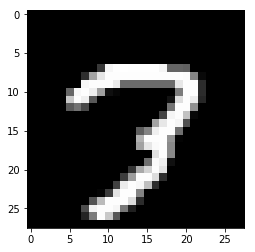

wrong answer given: 7


In [58]:
import random

# show some of the failed images

for i in range(1):
	x = random.randrange(len(failed))
	bad_image, wrong_answer = failed[x]
	plt.imshow(bad_image[0, :, :], cmap="gray")
	plt.show()
	print("wrong answer given:", wrong_answer.item())


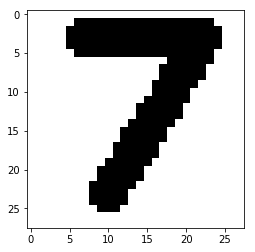

tensor([[ 2184.4480, -1508.3348, -1272.9540,  -456.0590,  -852.1781,   445.4189,
           -86.7253,   626.3904,   -98.0121,   139.4246]], device='cuda:0',
       grad_fn=<AddmmBackward>)
0


In [69]:
import cv2

# load a home-made image
test_image_path = "./HomeTests/04-7.png"
test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(test_image, cmap="gray")
plt.show()
test_image_tensor = torch.tensor(test_image, dtype=torch.float).to(device)
test_image_tensor = test_image_tensor[None, None, :, :]
test_output = net(test_image_tensor)
print(test_output)
print(classes[torch.argmax(test_output, dim=1).item()])

